Below we demonstrate the use of the object oriented wrapper for `multinterp`, which we call `MultivariateInterp`, and compare timings to `scipy.interpolate`'s `RegularGridInterpolator`.


In [1]:
from __future__ import annotations

from itertools import product
from time import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from multinterp.rectilinear._multi import MultivariateInterp
from scipy.interpolate import RegularGridInterpolator

Suppose we are trying to approximate the following function at a set of points:



In [2]:
def squared_coords(*x):
    return sum(xi**2 for xi in x)

Our points will lie on a regular or rectilinear grid. A rectilinear grid may not be evenly spaced, but it can be reproduced by the cross product of $n$ 1-dimensional vectors. For example, let's assume we know the value of the function at the following points:


In [3]:
x_grid = np.geomspace(1, 11, 11) - 1
y_grid = np.geomspace(1, 11, 11) - 1
x_mat, y_mat = np.meshgrid(x_grid, y_grid, indexing="ij")

z_mat = squared_coords(x_mat, y_mat)

Notice that the points are not evenly spaced, which is achieved with the use of `np.geomspace`. So now, we know the value of the function `squared_coords` and have labeled them as `z_mat`. Now suppose that we would like to know the value of the function at the points `x_new` and `y_new` which create an evenly spaced regular grid.


In [4]:
x_new, y_new = np.meshgrid(
    np.linspace(0, 10, 11),
    np.linspace(0, 10, 11),
    indexing="ij",
)

We can use scipy's `RegularGridInterpolator` to interpolate the function at these new points and then we can plot the results.


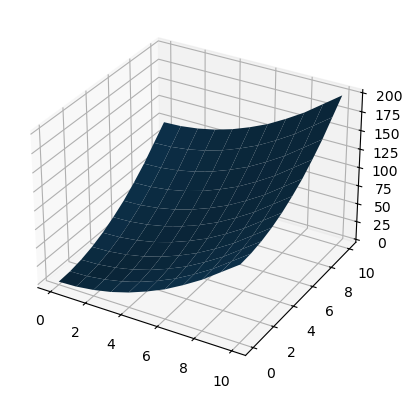

In [5]:
# | label: fig:multivariate_regular

interp = RegularGridInterpolator([x_grid, y_grid], z_mat)
z_interp = interp(np.column_stack((x_new.ravel(), y_new.ravel()))).reshape(x_new.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_new, y_new, z_interp)
plt.show()

In [6]:
%%timeit
z_interp = interp(np.column_stack((x_new.ravel(), y_new.ravel()))).reshape(x_new.shape)

44.5 μs ± 914 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Here we introduce `MultivariateInterp`, which brings additional features and speed improvements. The key feature of `MultivariateInterp` is its `backend` parameter, which can be set to `scipy`, `numba`, or `cupy`, among others. This allows the user to specify the backend device for the interpolation. Using `MultivariateInterp` mirrors the use of `RegularGridInterpolator` very closely.


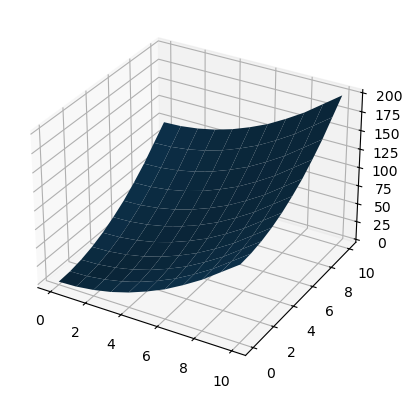

In [7]:
# | label: fig:multivariate_interp

mult_interp = MultivariateInterp(z_mat, [x_grid, y_grid])
z_mult_interp = mult_interp(x_new, y_new)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_new, y_new, z_mult_interp)
plt.show()

In [8]:
%%timeit
z_mult_interp = mult_interp(x_new, y_new)

17.6 μs ± 412 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


As we see above, `MultivariateInterp` is faster than `RegularGridInterpolator`, even with the default `backend="scipy"`. Moreover, the speed of `MultivariateInterp` is highly dependent on the number of points in the grid and the backend device. For example, for a large number of points, `MultivariateInterp` with `backend='numba'` can be shown to be significantly faster than `RegularGridInterpolator`.


In [9]:
gpu_interp = MultivariateInterp(z_mat, [x_grid, y_grid], backend="cupy")
z_gpu_interp = gpu_interp(x_new, y_new).get()  # Get the result from GPU

In [10]:
%%timeit
z_gpu_interp = gpu_interp(x_new, y_new).get()  # Get the result from GPU

655 μs ± 166 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can test the results of `MultivariateInterp` against `RegularGridInterpolator`, and we see that the results are almost identical.


In [11]:
np.allclose(z_interp - z_gpu_interp, z_mult_interp - z_gpu_interp)

True

To experiment with `MultivariateInterp` and evaluate the conditions which make it faster than `RegularGridInterpolator`, we can create a grid of data points and interpolation points and then time the interpolation on different backends.


In [12]:
n = 35
grid_max = 500
grid = np.linspace(10, grid_max, n, dtype=int)
fast = np.empty((n, n))
scipy = np.empty_like(fast)
parallel = np.empty_like(fast)
gpu = np.empty_like(fast)

We will use the following function to time the execution of the interpolation.



In [13]:
def timeit(interp, *coords):
    if isinstance(interp, RegularGridInterpolator):
        start = time()
        points = np.column_stack([coord.ravel() for coord in coords])
        interp(points).reshape(coords[0].shape)
    else:
        interp.compile()
        start = time()
        interp(*coords)

    elapsed_time = time() - start
    return max(elapsed_time, 1e-6)

For different number of data points and approximation points, we can time the interpolation on different backends and use the results of `RegularGridInterpolator` to normalize the results. This will give us a direct comparison of the speed of `MultivariateInterp` and `RegularGridInterpolator`.


In [14]:
for i, j in product(range(n), repeat=2):
    data_grid = np.linspace(0, 10, grid[i])
    x_cross, y_cross = np.meshgrid(data_grid, data_grid, indexing="ij")
    z_cross = squared_coords(x_cross, y_cross)

    approx_grid = np.linspace(0, 10, grid[j])
    x_approx, y_approx = np.meshgrid(approx_grid, approx_grid, indexing="ij")

    fast_interp = RegularGridInterpolator([data_grid, data_grid], z_cross)
    time_norm = timeit(fast_interp, x_approx, y_approx)
    fast[i, j] = time_norm

    scipy_interp = MultivariateInterp(z_cross, [data_grid, data_grid], backend="scipy")
    scipy[i, j] = timeit(scipy_interp, x_approx, y_approx) / time_norm

    par_interp = MultivariateInterp(z_cross, [data_grid, data_grid], backend="numba")
    parallel[i, j] = timeit(par_interp, x_approx, y_approx) / time_norm

    gpu_interp = MultivariateInterp(z_cross, [data_grid, data_grid], backend="cupy")
    gpu[i, j] = timeit(gpu_interp, x_approx, y_approx) / time_norm

Text(0.5, 0.75, 'Benchmarks for 2D Interpolation')

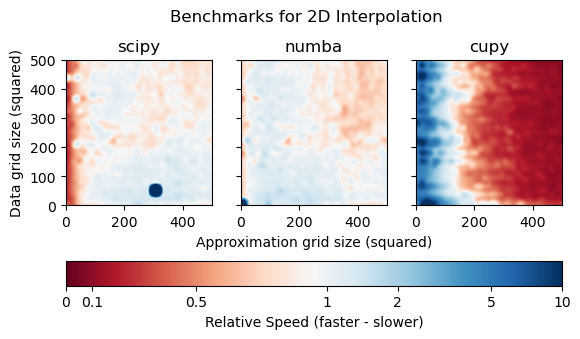

In [15]:
# | label: fig:multivariate_speed_2d

fig, ax = plt.subplots(1, 3, sharey=True)


ax[0].imshow(
    scipy,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[0].set_title("scipy")


ax[1].imshow(
    parallel,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[1].set_title("numba")

cbar = ax[2].imshow(
    gpu,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[2].set_title("cupy")


cbar = fig.colorbar(
    cbar,
    ax=ax,
    label="Relative Speed (faster - slower)",
    location="bottom",
)
cbar.set_ticks([0, 0.1, 0.5, 1, 2, 5, 10])
cbar.set_ticklabels(["0", "0.1", "0.5", "1", "2", "5", "10"])
ax[0].set_ylabel("Data grid size (squared)")
ax[1].set_xlabel("Approximation grid size (squared)")

fig.suptitle("Benchmarks for 2D Interpolation", y=0.75)

In [16]:
n = 20
grid_max = 200
grid = np.linspace(10, grid_max, n, dtype=int)
fast = np.empty((n, n))
scipy = np.empty_like(fast)
parallel = np.empty_like(fast)
gpu = np.empty_like(fast)

In [17]:
for i, j in product(range(n), repeat=2):
    data_grid = np.linspace(0, 10, grid[i])
    x_cross, y_cross, w_cross = np.meshgrid(
        data_grid,
        data_grid,
        data_grid,
        indexing="ij",
    )
    z_cross = squared_coords(x_cross, y_cross, w_cross)

    approx_grid = np.linspace(0, 10, grid[j])
    x_approx, y_approx, w_approx = np.meshgrid(
        approx_grid,
        approx_grid,
        approx_grid,
        indexing="ij",
    )

    fast_interp = RegularGridInterpolator([data_grid, data_grid, data_grid], z_cross)
    time_norm = timeit(fast_interp, x_approx, y_approx, w_approx)
    fast[i, j] = time_norm

    scipy_interp = MultivariateInterp(
        z_cross,
        [data_grid, data_grid, data_grid],
        backend="scipy",
    )
    scipy[i, j] = timeit(scipy_interp, x_approx, y_approx, w_approx) / time_norm

    par_interp = MultivariateInterp(
        z_cross,
        [data_grid, data_grid, data_grid],
        backend="numba",
    )
    parallel[i, j] = timeit(par_interp, x_approx, y_approx, w_approx) / time_norm

    gpu_interp = MultivariateInterp(
        z_cross,
        [data_grid, data_grid, data_grid],
        backend="cupy",
    )
    gpu[i, j] = timeit(gpu_interp, x_approx, y_approx, w_approx) / time_norm

Text(0.5, 0, 'Approximation grid size (squared)')

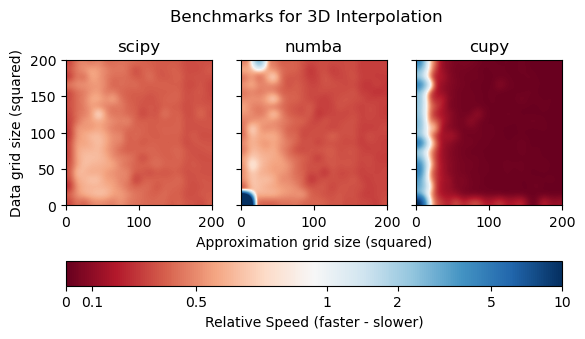

In [18]:
# | label: fig:multivariate_speed_3d

fig, ax = plt.subplots(1, 3, sharey=True)

fig.suptitle("Benchmarks for 3D Interpolation", y=0.75)


ax[0].imshow(
    scipy,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[0].set_title("scipy")


ax[1].imshow(
    parallel,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[1].set_title("numba")

cbar = ax[2].imshow(
    gpu,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[2].set_title("cupy")


cbar = fig.colorbar(
    cbar,
    ax=ax,
    label="Relative Speed (faster - slower)",
    location="bottom",
)
cbar.set_ticks([0, 0.1, 0.5, 1, 2, 5, 10])
cbar.set_ticklabels(["0", "0.1", "0.5", "1", "2", "5", "10"])
ax[0].set_ylabel("Data grid size (squared)")
ax[1].set_xlabel("Approximation grid size (squared)")

As we can see from the results, `MultivariateInterp` is faster than `RegularGridInterpolator` depending on the number of points and the backend device. A value of 1 represents the same speed as `RegularGridInterpolator`, while a value less than 1 is faster (in red) and a value greater than 1 is slower (in blue).

For `backend="scipy"`, `MultivariateInterp` is (much) slower when the number of approximation points that need to be interpolated is very small, as seen by the deep blue areas. When the number of approximation points is moderate to large, however, `MultivariateInterp` is about as fast as `RegularGridInterpolator`.

For `backend="numba"`, `MultivariateInterp` is slightly faster when the number of data points with known function value are greater than the number of approximation points that need to be interpolated. However, `backend='parallel'` still suffers from the high overhead when the number of approximation points is small.

For `backend="cupy"`, `MultivariateInterp` is much slower when the number of data points with known function value are small. This is because of the overhead of copying the data to the GPU. However, `backend='numba'` is significantly faster for any other case when the number of approximation points is large regardless of the number of data points.



